# Exploring Environment Canada Weather Data with Python and Jupyter Notebooks

- Based on the code given by [Siang Lim](https://github.com/csianglim/weather-gc-ca-python/blob/master/Part%20I%20-%20Data%20Extraction%20and%20Cleaning.ipynb)

This notebook demonstrates how to download Environment Canada's weather data using Python with popular data analysis libraries like pandas and Beautiful Soup.

# Part I: Data Extraction & Cleaning

In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil import rrule
from datetime import datetime, timedelta
from bs4 import BeautifulSoup
import requests
import re

In [4]:
!pip install fuzzywuzzy
!pip install python-Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.7/103.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 16.8 MB/s eta 0:00:00a 0:00:01


In [2]:
# We'll need `fuzzywuzzy` to look up weather stations later
# Run "!pip install fuzzywuzzy --user" if you get an error

# !pip install fuzzywuzzy --user
from fuzzywuzzy import fuzz

## How to download one month of data:

In [12]:
month = "07"  # January
year = "2024"  # 2020
day = "01"
stationID = 4715  # Vancouver

base_url = "http://climate.weather.gc.ca/climate_data/bulk_data_e.html?"
query_url = "format=csv&stationID={}&Year={}&Month={}&Day={}&timeframe=1".format(
    stationID, year, month, day
)
api_endpoint = base_url + query_url

print("Click me to download CSV data:")
print(api_endpoint)

Click me to download CSV data:
http://climate.weather.gc.ca/climate_data/bulk_data_e.html?format=csv&stationID=4715&Year=2024&Month=07&Day=01&timeframe=1


## Function for calling the Environment Canada API

In [4]:
# Call Environment Canada API
# Returns a dataframe of data
# def getHourlyData(stationID, year, month, day):
def getHourlyData(stationID, year, month):
    base_url = "http://climate.weather.gc.ca/climate_data/bulk_data_e.html?"
    # query_url = "format=csv&stationID={}&Year={}&Month={}&Day={}&timeframe=1".format(stationID, year, month, day)
    query_url = "format=csv&stationID={}&Year={}&Month={}&timeframe=1".format(
        stationID, year, month
    )
    api_endpoint = base_url + query_url
    return pd.read_csv(api_endpoint, skiprows=0)

## How to download data between a specified date range

In [5]:
stationID = 42967
start_date = datetime.strptime('01 June 2024', '%d %B %Y')
end_date = datetime.strptime('7 August 2024', '%d %B %Y')

frames = []
for dt in rrule.rrule(rrule.MONTHLY, dtstart=start_date, until=end_date):
    # for dt in rrule.rrule(rrule.DAILY, dtstart=start_date, until=end_date):
    # df = getHourlyData(stationID, dt.year, dt.month, dt.day)
    df = getHourlyData(stationID, dt.year, dt.month)
    frames.append(df)

weather_data = pd.concat(frames)
weather_data['Date/Time (LST)'] = pd.to_datetime(weather_data['Date/Time (LST)'])
weather_data['Temp (°C)'] = pd.to_numeric(weather_data['Temp (°C)'])
weather_data['Station ID'] = stationID

In [84]:
start_date.timestamp()

1714536000.0

In [86]:
weather_data['Date_Time_Num'] = weather_data['Date/Time (LST)'].apply(
    lambda td: td.timestamp()
)

In [89]:
weather_data['Date_Time_Num'].max()

1722466800.0

In [92]:
thres = 0.8


def dosplit_train(df: pd.DataFrame):

    min_date = df['Date_Time_Num'].min()
    max_date = df['Date_Time_Num'].max()

    a = df['Date_Time_Num'] <= (min_date + thres * (max_date - min_date))
    return df[a]


def dosplit_val(df: pd.DataFrame):

    min_date = df['Date_Time_Num'].min()
    max_date = df['Date_Time_Num'].max()

    a = df['Date_Time_Num'] > (min_date + thres * (max_date - min_date))
    return df[a]

In [79]:
weather_data['Date (LST)'] = weather_data['Date/Time (LST)'].dt.date

In [80]:
weather_data['Mean Temp (°C)'] = (
    weather_data['Temp (°C)'].groupby(weather_data['Date (LST)']).transform('mean')
)

In [81]:
weather_data['Mean Temp (°C)'].isnull().sum()

3600

In [8]:
weather_data_1 = weather_data[weather_data['Stn Press (kPa)'].notna()]

In [7]:
weather_data.head()

,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time (LST),Year,Month,Day,Time (LST),Temp (°C),...,Visibility (km),Visibility Flag,Stn Press (kPa),Stn Press Flag,Hmdx,Hmdx Flag,Wind Chill,Wind Chill Flag,Weather,Station ID
0,-78.27,45.53,ALGONQUIN PARK EAST GATE,6080192,2024-06-01 00:00:00,2024,6,1,00:00,6.0,...,NaN,NaN,97.47,NaN,NaN,NaN,NaN,NaN,NaN,42967
1,-78.27,45.53,ALGONQUIN PARK EAST GATE,6080192,2024-06-01 01:00:00,2024,6,1,01:00,5.2,...,NaN,NaN,97.49,NaN,NaN,NaN,NaN,NaN,NaN,42967
2,-78.27,45.53,ALGONQUIN PARK EAST GATE,6080192,2024-06-01 02:00:00,2024,6,1,02:00,4.1,...,NaN,NaN,97.48,NaN,NaN,NaN,NaN,NaN,NaN,42967
3,-78.27,45.53,ALGONQUIN PARK EAST GATE,6080192,2024-06-01 03:00:00,2024,6,1,03:00,3.2,...,NaN,NaN,97.48,NaN,NaN,NaN,NaN,NaN,NaN,42967
4,-78.27,45.53,ALGONQUIN PARK EAST GATE,6080192,2024-06-01 04:00:00,2024,6,1,04:00,2.5,...,NaN,NaN,97.48,NaN,NaN,NaN,NaN,NaN,NaN,42967


In [10]:
weather_data_1.tail()

,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time (LST),Year,Month,Day,Time (LST),Temp (°C),...,Visibility (km),Visibility Flag,Stn Press (kPa),Stn Press Flag,Hmdx,Hmdx Flag,Wind Chill,Wind Chill Flag,Weather,Station ID
139,-78.27,45.53,ALGONQUIN PARK EAST GATE,6080192,2024-08-06 19:00:00,2024,8,6,19:00,16.5,...,NaN,NaN,97.01,NaN,NaN,NaN,NaN,NaN,NaN,42967
140,-78.27,45.53,ALGONQUIN PARK EAST GATE,6080192,2024-08-06 20:00:00,2024,8,6,20:00,14.5,...,NaN,NaN,97.04,NaN,NaN,NaN,NaN,NaN,NaN,42967
141,-78.27,45.53,ALGONQUIN PARK EAST GATE,6080192,2024-08-06 21:00:00,2024,8,6,21:00,13.2,...,NaN,NaN,97.09,NaN,NaN,NaN,NaN,NaN,NaN,42967
142,-78.27,45.53,ALGONQUIN PARK EAST GATE,6080192,2024-08-06 22:00:00,2024,8,6,22:00,11.7,...,NaN,NaN,97.12,NaN,NaN,NaN,NaN,NaN,NaN,42967
143,-78.27,45.53,ALGONQUIN PARK EAST GATE,6080192,2024-08-06 23:00:00,2024,8,6,23:00,10.8,...,NaN,NaN,97.14,NaN,NaN,NaN,NaN,NaN,NaN,42967


In [96]:
training = weather_data.groupby('Date_Time_Num').apply(
    dosplit_train, include_groups=True
)

/var/folders/7v/syzn01012_3fnr7bzfw4zzl40000gp/T/ipykernel_94510/1547284833.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  training = weather_data.groupby('Date_Time_Num').apply(dosplit_train, include_groups=True)


## Plot average data and a rolling average
Notice the broken lines, they indicate missing data points.

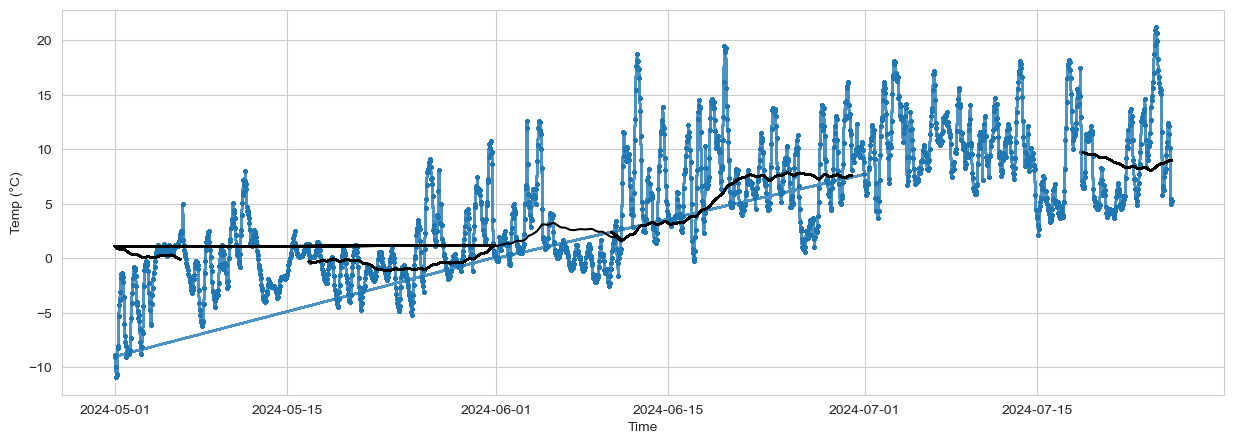

In [75]:
%matplotlib inline
sns.set_style('whitegrid')
fig = plt.figure(figsize=(15, 5))
plt.plot(
    weather_data['Date/Time (LST)'],
    weather_data['Temp (°C)'],
    '-o',
    alpha=0.8,
    markersize=2,
)
plt.plot(
    weather_data['Date/Time (LST)'],
    weather_data['Temp (°C)'].rolling(window=250, center=False).mean(),
    '-k',
    alpha=1.0,
)
plt.ylabel('Temp (°C)')
plt.xlabel('Time')
plt.show()

## Fix missing data points by interpolation

In [76]:
# Don't really care about accuracy right now, use simple linear interpolation
weather_data['Mean Temp (°C)'] = weather_data['Mean Temp (°C)'].interpolate()

In [77]:
weather_data['Mean Temp (°C)'].isnull().sum()

0

Then plot the data again:

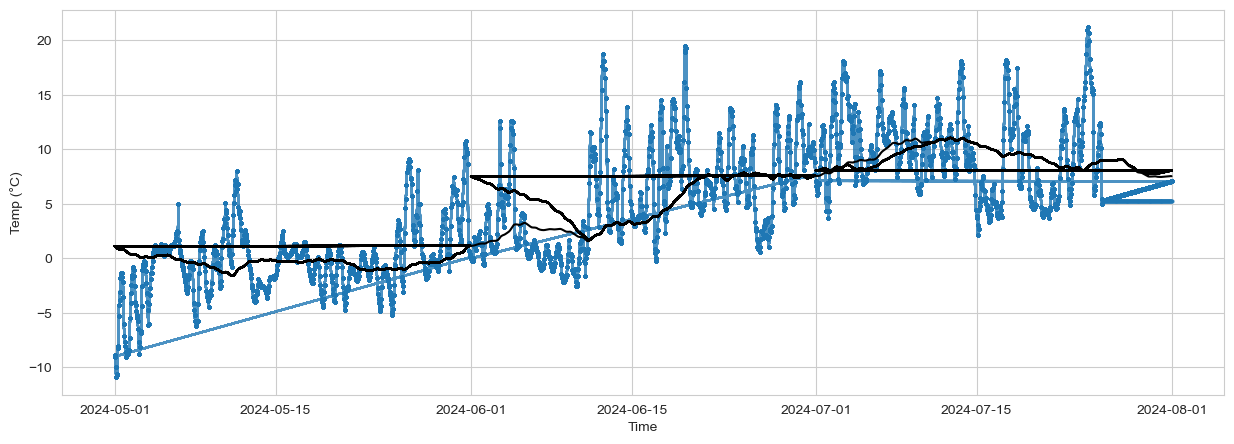

In [58]:
%matplotlib inline
sns.set_style('whitegrid')
fig = plt.figure(figsize=(15, 5))
plt.plot(
    weather_data['Date/Time (LST)'],
    weather_data['Temp (°C)'],
    '-o',
    alpha=0.8,
    markersize=2,
)
plt.plot(
    weather_data['Date/Time (LST)'],
    weather_data['Temp (°C)'].rolling(window=250, center=False).mean(),
    '-k',
    alpha=1.0,
)
plt.ylabel('Temp (°C)')
plt.xlabel('Time')
plt.show()

## For convenience: Scrape StationIDs to lookup cities
This section demonstrates a simple Python script for scraping StationIDs from Environment Canada using Beautiful Soup.

The stationIDs are provided by province in this Environment Canada [page](http://climate.weather.gc.ca/historical_data/search_historic_data_e.html). Environment Canada limits the number of rows in the search results to 100 entries. This script loops through all pages and grabs the StationID, Station Name, Intervals and Year Range.


## Parsing the Environment Canada page with Beautiful Soup

In [10]:
def parse_station_id(soup_frames, province):
    # Empty list to store the station data
    station_data = []

    for soup in soup_frames:  # For each soup
        forms = soup.findAll(
            "form", {"id": re.compile('stnRequest*')}
        )  # We find the forms with the stnRequest* ID using regex
        for form in forms:
            try:
                # The stationID is a child of the form
                station = form.find("input", {"name": "StationID"})['value']

                # The station name is a sibling of the input element named lstProvince
                name = (
                    form.find("input", {"name": "lstProvince"})
                    .find_next_siblings("div")[0]
                    .text
                )

                # The intervals are listed as children in a 'select' tag named timeframe
                timeframes = form.find("select", {"name": "timeframe"}).findChildren()
                intervals = [t.text for t in timeframes]

                # We can find the min and max year of this station using the first and last child
                years = form.find("select", {"name": "Year"}).findChildren()
                min_year = years[0].text
                max_year = years[-1].text

                # Store the data in an array
                data = [station, name, intervals, min_year, max_year, province]
                station_data.append(data)
            except:
                pass

    # Create a pandas dataframe using the collected data and give it the appropriate column names
    stations_df = pd.DataFrame(
        station_data,
        columns=[
            'StationID',
            'Name',
            'Intervals',
            'Year Start',
            'Year End',
            'Province',
        ],
    )
    # stations_df.head()
    stations_df.to_csv(f'stations_{province}.csv')

In [11]:
# Specify Parameters
provinces = [
    "AB",
    "BC",
    "MB",
    "NB",
    "NL",
    "NT",
    "NS",
    "NU",
    "ON",
    "PE",
    "QC",
    "SK",
    "YT",
]  # Province list
max_pages = [
    4,
    4,
    2,
    1,
    1,
    1,
    1,
    2,
    4,
    1,
    4,
    2,
    1,
]  #  Number of pages knowing that each display 100 rows
nb_stations = [
    319,
    367,
    107,
    40,
    95,
    99,
    67,
    124,
    308,
    17,
    332,
    117,
    48,
]  # number of stations since 2014
start_year = "2014"  # I want the results to go back to at least 2006 or earlier


for idx, province in enumerate(provinces):
    # Store each page in a list and parse them later
    soup_frames = []
    for i in range(max_pages[idx]):
        startRow = 1 + i * 100
        print(f'Downloading Page: {i} for province {province}')

        base_url = "http://climate.weather.gc.ca/historical_data/search_historic_data_stations_e.html?"
        queryProvince = (
            f"searchType=stnProv&timeframe=1&lstProvince={province}&optLimit=yearRange&"
        )
        queryYear = f"StartYear={start_year}&EndYear=2024&Year=2024&Month=7&Day=20&selRowPerPage=100&txtCentralLatMin=0&txtCentralLatSec=0&txtCentralLongMin=0&txtCentralLongSec=0&"
        queryStartRow = f"startRow={startRow}"

        response = requests.get(
            base_url + queryProvince + queryYear + queryStartRow
        )  # Using requests to read the HTML source
        soup = BeautifulSoup(response.text, 'html.parser')  # Parse with Beautiful Soup
        soup_frames.append(soup)
    parse_station_id(soup_frames, province)

KeyboardInterrupt: 

## Filtering Station Data
For example, to show only stations with hourly data, use the map() function.

In [17]:
# Show only data with hourly intervals
hourly_stations = stations_df.loc[stations_df['Intervals'].map(lambda x: 'Hourly' in x)]
hourly_stations.head()

,StationID,Name,Intervals,Year Start,Year End
2,702,ABBOTSFORD A,"[Hourly, Daily, Monthly]",1953,2012
3,50308,ABBOTSFORD A,"[Hourly, Daily]",2011,2024
4,54238,ABBOTSFORD A,"[Hourly, Daily]",2016,2024
5,374,ADDENBROKE ISLAND,"[Hourly, Daily, Monthly]",1994,2001
7,706,AGASSIZ RCS,"[Hourly, Daily, Monthly]",1994,2024


## Looking up stations
Now that we have the stationIDs, we can use Fuzzywuzzy and fuzzy string matching to lookup the station IDs with the city names. Here are 2 examples

In [18]:
# Find the stations that are in Whistler
string = "Whistler"
tolerance = 90

hourly_stations[
    hourly_stations['Name'].apply(lambda x: fuzz.token_set_ratio(x, string)) > tolerance
]

,StationID,Name,Intervals,Year Start,Year End
467,348,WHISTLER,"[Hourly, Daily, Monthly]",1983,2014
468,43443,WHISTLER - NESTERS,"[Hourly, Daily, Monthly]",2005,2024
469,52178,WHISTLER A,[Hourly],2014,2024
470,43660,WHISTLER MOUNTAIN HIGH LEVEL,"[Hourly, Daily, Monthly]",2005,2010
471,44463,WHISTLER MOUNTAIN HIGH LEVEL REMOTE WIND,"[Hourly, Daily]",2005,2010
472,43680,WHISTLER MOUNTAIN LOW LEVEL,"[Hourly, Daily, Monthly]",2005,2010
473,46307,WHISTLER MOUNTAIN MID-STATION,"[Hourly, Daily]",2007,2010
474,47867,WHISTLER MOUNTAIN TIMING FLATS,"[Hourly, Daily]",2009,2010


In [19]:
# Find the stations that are in Vancouver
string = "Vancouver"
tolerance = 90

hourly_stations[
    hourly_stations['Name'].apply(lambda x: fuzz.token_set_ratio(x, string)) > tolerance
]

,StationID,Name,Intervals,Year Start,Year End
434,888,VANCOUVER HARBOUR CS,"[Hourly, Daily, Monthly]",1976,2024
435,48328,VANCOUVER HILLCREST,"[Hourly, Daily]",2009,2010
436,889,VANCOUVER INT'L A,"[Hourly, Daily, Monthly]",1953,2013
438,51442,VANCOUVER INTL A,"[Hourly, Daily]",2013,2024
440,51357,VANCOUVER SEA ISLAND CCG,"[Hourly, Daily]",2013,2024
465,6833,WEST VANCOUVER AUT,"[Hourly, Daily, Monthly]",1994,2024


## Download Weather Data
Now that we know the station ID, we can use our getHourlyData() function to call the Environment Canada API with the station ID that we found. 

Here's how we get Whistler data from November 2016 to November 2017:

In [21]:
# Get Whistler weather data for November 2016 to November 2017
stationID = 43443
start_date = datetime.strptime('Nov2016', '%b%Y')
end_date = datetime.strptime('Nov2017', '%b%Y')

frames = []
for dt in rrule.rrule(rrule.MONTHLY, dtstart=start_date, until=end_date):
    df = getHourlyData(stationID, dt.year, dt.month)
    frames.append(df)

whistler = pd.concat(frames)
whistler['Date/Time (LST)'] = pd.to_datetime(whistler['Date/Time (LST)'])
whistler['Temp (°C)'] = pd.to_numeric(whistler['Temp (°C)'])
whistler.head()

,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time (LST),Year,Month,Day,Time (LST),Temp (°C),...,Wind Spd Flag,Visibility (km),Visibility Flag,Stn Press (kPa),Stn Press Flag,Hmdx,Hmdx Flag,Wind Chill,Wind Chill Flag,Weather
0,-122.95,50.13,WHISTLER - NESTERS,1100875,2016-11-01 00:00:00,2016,11,1,00:00,4.3,...,M,NaN,NaN,93.12,NaN,NaN,NaN,NaN,NaN,NaN
1,-122.95,50.13,WHISTLER - NESTERS,1100875,2016-11-01 01:00:00,2016,11,1,01:00,4.4,...,M,NaN,NaN,93.13,NaN,NaN,NaN,NaN,NaN,NaN
2,-122.95,50.13,WHISTLER - NESTERS,1100875,2016-11-01 02:00:00,2016,11,1,02:00,4.1,...,M,NaN,NaN,93.19,NaN,NaN,NaN,NaN,NaN,NaN
3,-122.95,50.13,WHISTLER - NESTERS,1100875,2016-11-01 03:00:00,2016,11,1,03:00,4.0,...,M,NaN,NaN,93.19,NaN,NaN,NaN,NaN,NaN,NaN
4,-122.95,50.13,WHISTLER - NESTERS,1100875,2016-11-01 04:00:00,2016,11,1,04:00,4.1,...,M,NaN,NaN,93.17,NaN,NaN,NaN,NaN,NaN,NaN


## Let's plot the data for Whistler

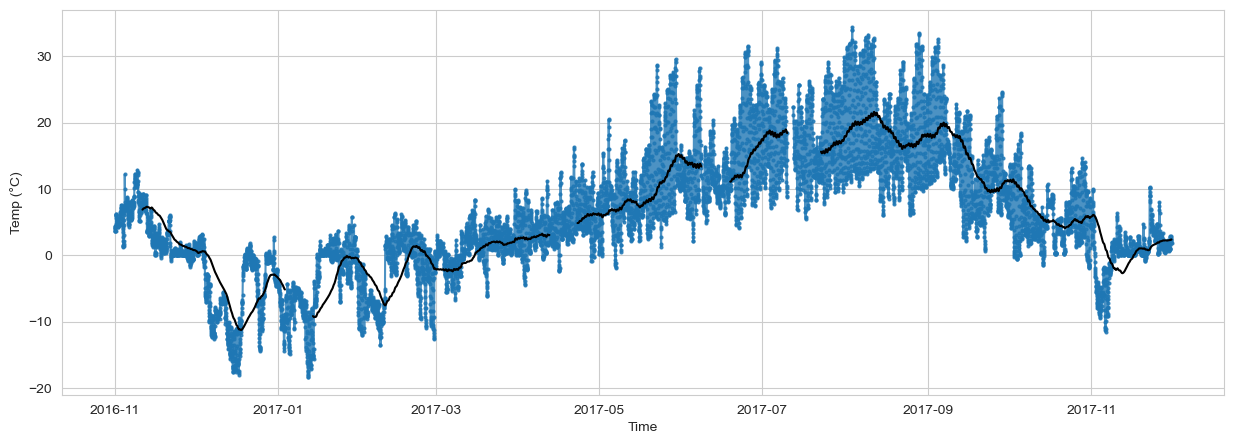

In [23]:
%matplotlib inline
sns.set_style('whitegrid')
fig = plt.figure(figsize=(15, 5))
plt.plot(
    whistler['Date/Time (LST)'], whistler['Temp (°C)'], '-o', alpha=0.8, markersize=2
)
plt.plot(
    whistler['Date/Time (LST)'],
    whistler['Temp (°C)'].rolling(window=250, center=False).mean(),
    '-k',
    alpha=1.0,
)
plt.ylabel('Temp (°C)')
plt.xlabel('Time')
plt.show()

## How to fix missing data points with interpolation

In [24]:
# Find the number of rows with a 'M' for missing temperature flag, or NaN for the actual temperature value
print(
    'Missing data rows: ',
    whistler.loc[
        (~whistler['Temp Flag'].isnull()) | (whistler['Temp (°C)'].isnull())
    ].shape[0],
)

# Do interpolation
whistler['Temp (°C)'] = whistler['Temp (°C)'].interpolate()

# Did we fix everything?
print('Missing data rows: ', whistler.loc[(whistler['Temp (°C)'].isnull())].shape[0])

Missing data rows:  63
Missing data rows:  0


Re-plot the data

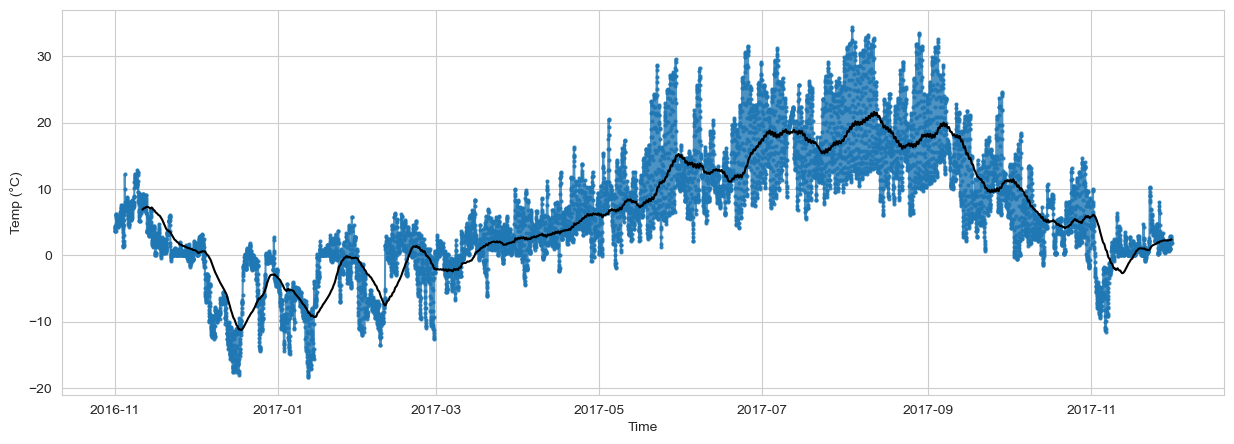

In [25]:
%matplotlib inline
sns.set_style('whitegrid')
fig = plt.figure(figsize=(15, 5))
plt.plot(
    whistler['Date/Time (LST)'], whistler['Temp (°C)'], '-o', alpha=0.8, markersize=2
)
plt.plot(
    whistler['Date/Time (LST)'],
    whistler['Temp (°C)'].rolling(window=250, center=False).mean(),
    '-k',
    alpha=1.0,
)
plt.ylabel('Temp (°C)')
plt.xlabel('Time')
plt.show()

# Exporting Data

We'll export the dataframes in CSV format so we don't have to re-download the data every time we restart Jupyter:

In [26]:
stations_df.to_csv('stations.csv')
whistler.to_csv('whistler.csv')

In [11]:
folder = 'data/Training/old/'
df_train = pd.read_csv(f'{folder}X_train.csv')
categorical = ['Station ID']
df_train[categorical] = df_train[categorical].astype(str)
df_val = pd.read_csv(f'{folder}X_val.csv')

In [12]:
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer()
train_dicts = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

In [19]:
import numpy as np

len(np.unique(df_train[categorical]))

124

In [15]:
X_train.shape

(135594, 125)

In [8]:
X_train[1:5, :]

<4x2 sparse matrix of type '<class 'numpy.float64'>'
	with 8 stored elements in Compressed Sparse Row format>